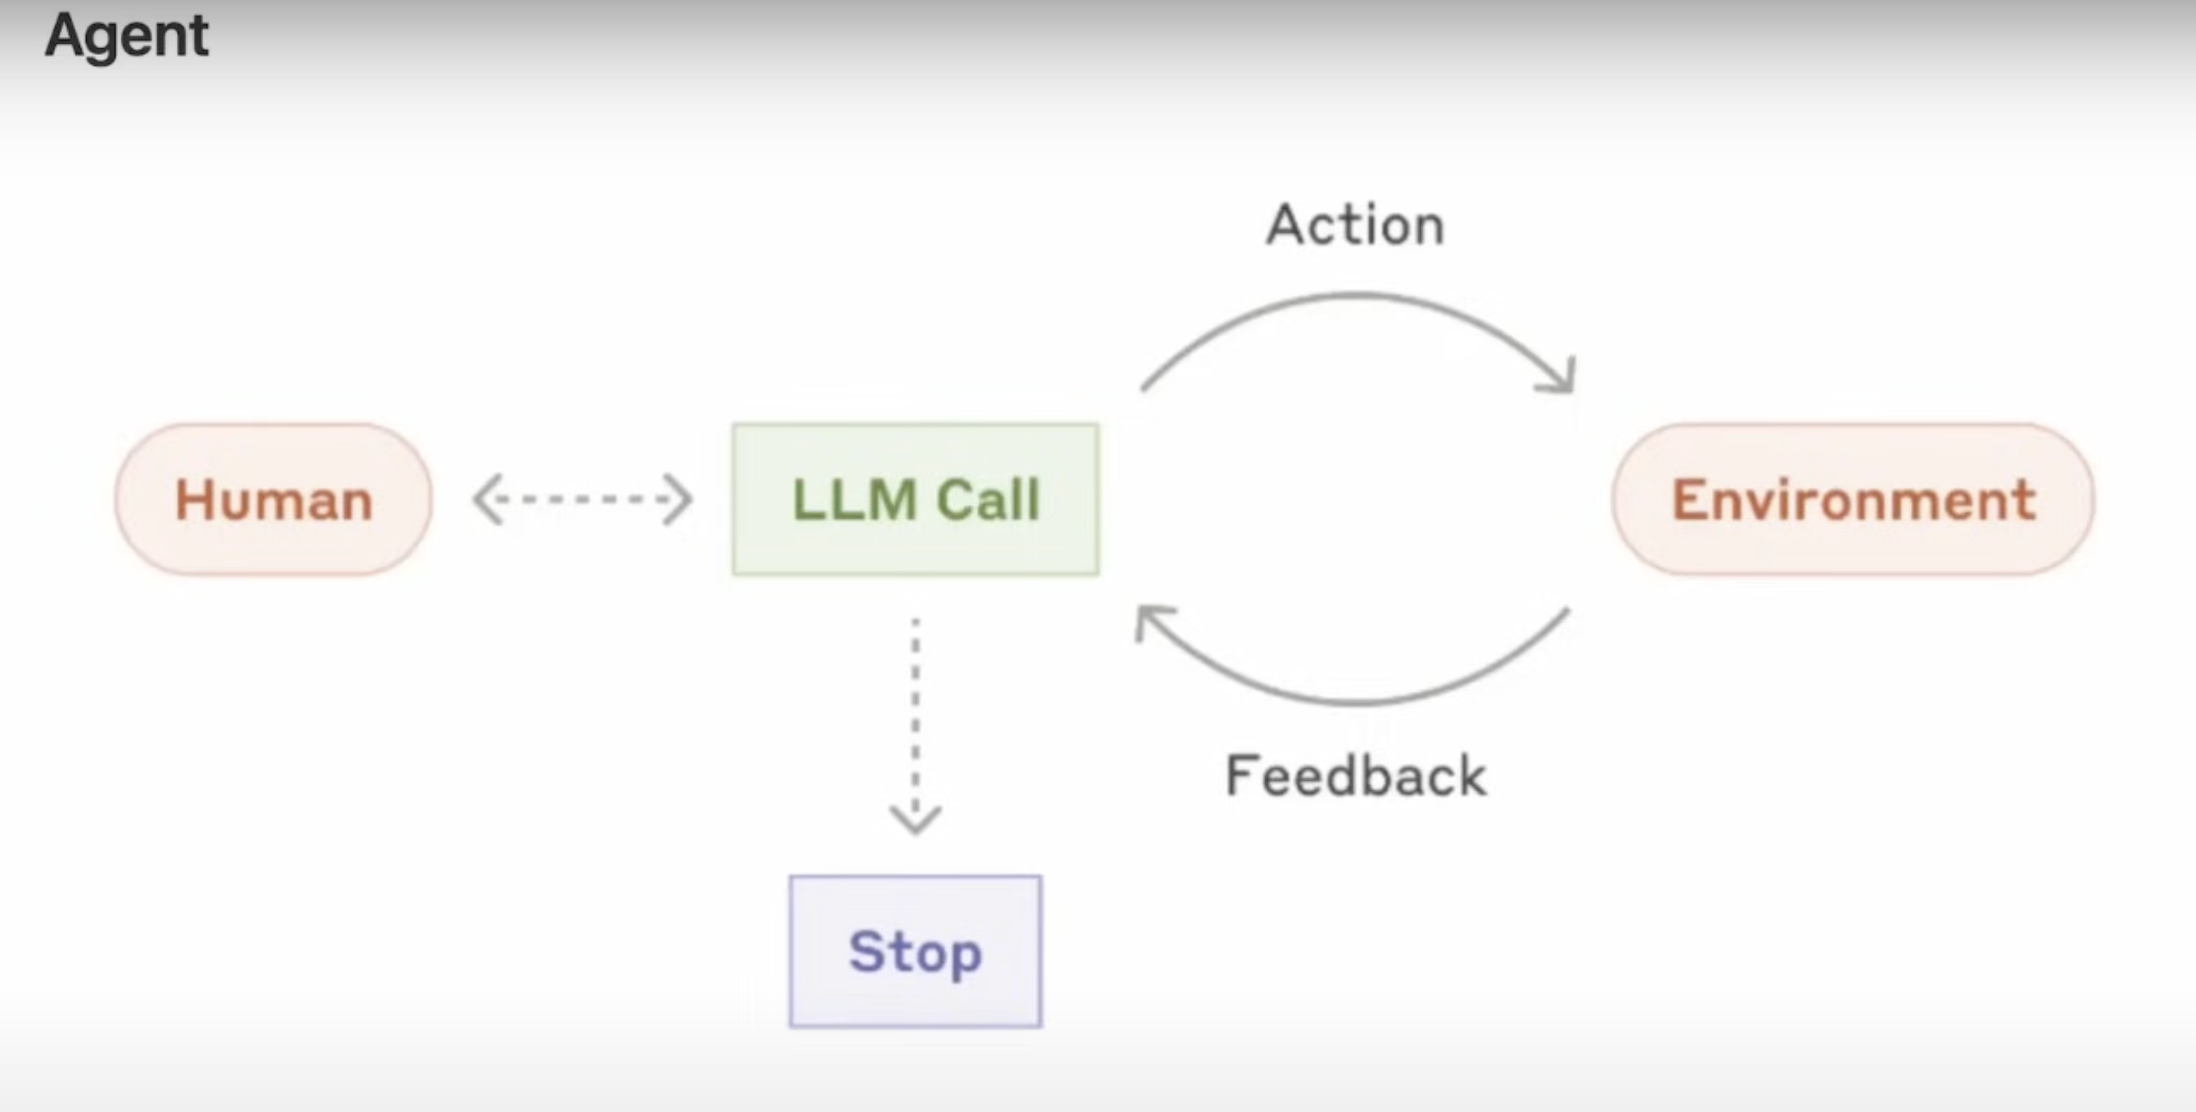

In [1]:
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from IPython.display import Image,display
import os

llm = ChatOpenAI(
    model_name="qwen-turbo-latest",
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)

/Users/daijunjie/miniconda3/envs/langchain-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
from langchain_core.tools import tool

# define tools
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b
@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name :tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

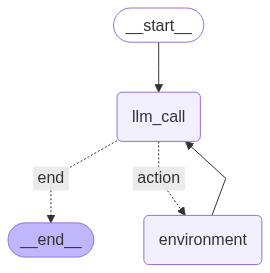

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage,SystemMessage,HumanMessage

# nodes
def llm_call(state:MessagesState):
    """llm decide whether to call tool or not"""
    return {
        "messages":[
            llm_with_tools.invoke(
                [
                    SystemMessage("You are a helpful assistant tasked with performing arithmetic operations.")
                    ] + state['messages'],
            ) 
        ]
    }

tool_node = ToolNode(tools= tools)
# # 可以用ToolNode替代，但这里展示手动实现
# def tool_node(state:dict):
#     """performs the tool call"""
#     result = []
#     # print(state['messages'][-1].tool_calls[0])
#     for tool_call in state['messages'][-1].tool_calls:
#         tool = tools_by_name[tool_call['name']]
#         tool_result = tool.invoke(tool_call['args'])
#         result.append(ToolMessage(content=tool_result,tool_call_id = tool_call['id']))
#     return {"messages": result} # tool messages


def should_continue(state:MessagesState):
    """decide if we should continue the loop or stop based upon whether the llm made a tool call"""
    messages = state['messages']
    last_message = messages[-1]
    # 有tool call 并且tool_calls非空
    if hasattr(last_message,"tool_calls") and len(last_message.tool_calls) > 0:
        return "action"
    else:
        return "end"
    

# define the graph
agent_builder = StateGraph(MessagesState)
# add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)
# add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "end":END,
        "action":"environment"
    }
)
agent_builder.add_edge("environment","llm_call")

agent = agent_builder.compile()

# show the agent
display(Image(agent.get_graph(xray=False).draw_mermaid_png()))

结果还是很神奇的，一个system message，加上历史消息，可以通过循环，分步解决问题。

In [20]:
for event in agent.stream({"messages":"add 3 and 4.Then,take the output and multiply it by 2."}):
    print(event)

{'llm_call': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1cf892c76269433db9672f', 'function': {'arguments': '{"a": 3, "b": 4}', 'name': 'add'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 312, 'total_tokens': 361, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-turbo-latest', 'system_fingerprint': None, 'id': 'chatcmpl-113f0c8a-d6ae-922d-adde-ecc49278ca46', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--da5ad7b0-f9e9-4a21-85e6-89fedfd2036d-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_1cf892c76269433db9672f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 312, 'output_tokens': 49, 'total_tokens': 361, 'input_token_details': {}, 'output_token_details': {}})]}}
{'environment': {'messages': [ToolMessage(content='7', name='add', id='e32bbae2-8316-4115-a6a6-e4fb76ab

In [21]:
messages = [HumanMessage("add 3 and 4.Then,take the output and multiply it by 2.")]
    # event['messages'][-1].pretty_print()
messages = agent.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 3 and 4.Then,take the output and multiply it by 2.
================================== Ai Message ==================================
Tool Calls:
  add (call_141403d449f04c8db70f1d)
 Call ID: call_141403d449f04c8db70f1d
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3be0aa2a88e04e7c9670b7)
 Call ID: call_3be0aa2a88e04e7c9670b7
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The final result is 14.
